# The pyabf Cookbook: Membrane Test Theory
_Code examples demonstrating how to calculate holding current (Ih), membrane resistance (Rm), access resistance (Ra), and membrane capacitance (Cm) of a neuron by inspecting the current responses to voltage changes using voltage-clamp mode and whole-cell configuration._

For more resources, see the pyABF project website: http://www.GitHub.com/swharden/pyABF

### Common variables
* $ V_{m} $ - voltage across the cell membrane at a cell at a given time
* $ I_{h} $ - average clamp current at the holding voltage (a.k.a. holding current)
* $ C_{m} $ - membrane capacitance
* $ \Delta V $ - difference in clamp command voltage for a step protocol
* $ \Delta V_{m} $ - the _actual_ change in $ V_{m} $ when the voltage clamp amplifier changes by $ V $*
* $ R_{a}, R_{s} $ - access resistance (synonymous with series resistance)
* $ R_{m} $ - membrane resistance (the true property of the cell membrane)
* $ R_{i} $ - total input resistance ($ R_{a}+R_{m} $)
* $ Q $ - charge (units are A*S, or Coulombs)
* $ I_{c} $ - integrated current over time (units are the same as $ Q $)
* $ I_{0} $ - the peak value of the current transient in response to a voltage step
* $ \tau $ - the time constant of the decay curve of a current transient in response to a voltage step


_* There is a subtle difference between $ \Delta V $ and $ \Delta V_{m} $ due to the fact that the voltage-clamp amplifier is clamping through the resistive $ R_{i} $ but the cell (situated in the middle of the $ R_{a} $ / $ R_{m} $ voltage divider) is only experiencing $ R_{m} $. Therefore, the true cellular voltage will not be exactly the clamp voltage. This is what is overcome by performing series resistance compensation (which we do not use in these examples)._

### Typical Strategy

* Fit the curve to find $ \tau $
* Extrapolate the curve to find $ I_{0} $
* Find charge using $ Q = \tau*I_{0} $
* Calculate $ C_{m} $ using $ C_{m}=Q/\Delta V $

# Sample Data
*And a crash course on extracting signal and command data from ABF files with the pyabf package*

This sample data was generated by recording a model cell (hardware). Its values according to Clampex are:

* Cm: 30.7 pF
* Rm: 517 MOhm
* Ra: 8 MOhm
* Tau: 0.25 ms
* Hold: -138.9 pA

First, prepare the environment and import the pyabf package:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
np.set_printoptions(precision=3)

import sys
sys.path.insert(0, '../src/')
import pyabf

Now let's load some files we will use throughout this document:

In [2]:
abfStep = pyabf.ABF(R"../data/model_vc_step.abf") # model cell
#abfStep = pyabf.ABF(R"../data/171116sh_0011.abf") # actual neuron

We will now inspect each of these files by graphing their signal (current) vs command (voltage)

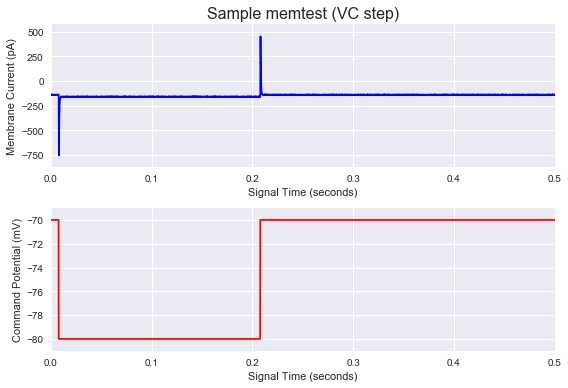

In [3]:
plt.subplot(211)
plt.plot(abfStep.dataX,abfStep.dataY,'b')
abfStep.plotDecorate(title="Sample memtest (VC step)")
plt.subplot(212)
plt.plot(abfStep.dataX,abfStep.dataC,'r')
abfStep.plotDecorate(command=True,title=False)

## Breaking data apart
We can use `abf.epochData(epochNumber)` to extract times/data/command from a single epoch:

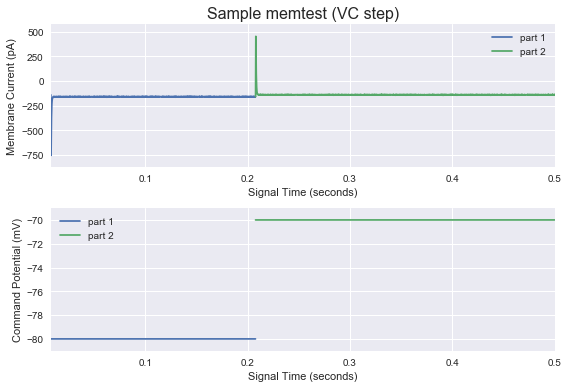

In [4]:
Xs1,Ys1,Cs1=abfStep.epochData(epochNumber=0)
Xs2,Ys2,Cs2=abfStep.epochData(epochNumber=1)

plt.subplot(211)
plt.plot(Xs1,Ys1,label="part 1")
plt.plot(Xs2,Ys2,label="part 2")
abfStep.plotDecorate(legend=True,title="Sample memtest (VC step)")

plt.subplot(212)
plt.plot(Xs1,Cs1,label="part 1")
plt.plot(Xs2,Cs2,label="part 2")
abfStep.plotDecorate(legend=True,command=True,title=None)

# Calculating Membrane Resistance ($ R_{m} $)
First we calculate $ {\Delta I} $, then using Ohm's law realize $ R_{m} = \Delta V / \Delta I $. This can be calculated using advanced features (shown below), but this quick and dirty calculation will get us started.

In [5]:
Xs1,Ys1,Cs1=abfStep.epochData(epochNumber=0)
Xs2,Ys2,Cs2=abfStep.epochData(epochNumber=1)
Im1=np.average(Ys1[-int(len(Ys1)/2):])
Im2=np.average(Ys2[-int(len(Ys1)/2):])
Vm1=Cs1[1]
Vm2=Cs2[1]
dVm=np.abs(Vm1-Vm2)
dIm=np.abs(Im1-Im2)
Rm=((dVm*1e-3)/(dIm*1e-12))*1e-6
print("clamp voltages (mV):", Vm1, Vm2)
print("delta V (mV):", dVm)
print("steady state currents (pA):", Im1, Im2)
print("delta I (pA):", dIm)
print("Rm (MOhm):",Rm)

clamp voltages (mV): -80.0 -70.0
delta V (mV): 10.0
steady state currents (pA): -158.812 -139.201
delta I (pA): 19.611
Rm (MOhm): 509.917306501


# Calculating Membrane Capacitance ($ C_{m} $)
There are several methods to calculate $ C_{m} $, each with their advantages and disadvantages. When reviewing the topic, I found these resources useful: [Membrane Capacitance Measurements Revisited](http://jn.physiology.org/content/102/4/2161) and [Accurate cell capacitance determination from a single voltage step](http://ajpheart.physiology.org/content/ajpheart/311/4/H1072.full.pdf)


## Method 1: Curve-Fitting
***A pretty good estimation of $ C_{m} $ can be found by integrating the transient of a voltage-clamp step***

The idea here is that the integrated transient ($ I_{d} $) is a pretty good approximation of $ C_{m} $ and can be performed with minimal complexity.

We start by focusing in on a single transient. Let's take the first one for simplicity.

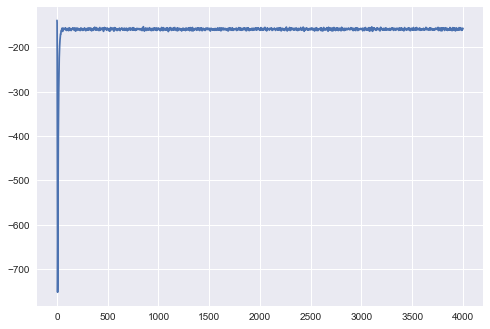

In [6]:
Xs,Ys,Cs=abfStep.epochData(epochNumber=0)
plt.plot(Ys);

We need to center this data on the steady state current. In quiet data like this, the easiest way is just to get the average of the last half of the segment.

Although an average (perhaps the average of the last 50% of the data) is good in quiet data, the pyabf package has a "tonic" function hidden away that determines steady state values as the peak of the curve-fitted histogram of the data:

```python
# alternative method of determining steady state
steadyState=abfStep._tonic(lastHalf)
```

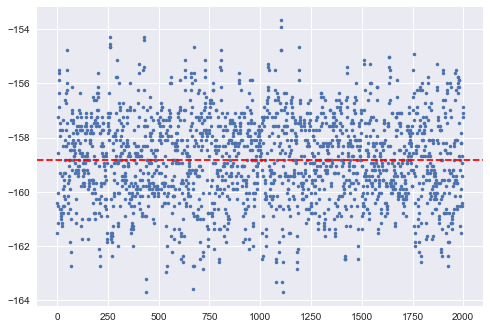

In [7]:
lastHalf=Ys[-int(len(Ys)/2):] # get only the last half of the epoch segment
plt.plot(lastHalf,'.')
steadyState=np.average(lastHalf)
plt.axhline(steadyState,ls='--',color='r');

Now subtract-out the steady state from the original data to center it at 0. Then invert it so we always work with positive units.

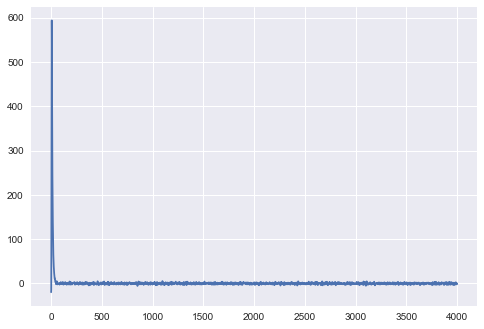

In [8]:
Ys-=steadyState
Ys*=-1
plt.plot(Ys);

Let's delete uninteresting data (the first few points below 0, and all the points after the trace returns to 0)

In [9]:
print(Ys)
cutOffFirstPoints=np.where(Ys>0)[0][0]
Ys=Ys[cutOffFirstPoints:] # cut-off the fist few data points below 0
Ys=Ys[:np.where(Ys<=0)[0][0]] # only keep data until zero is crossed again
print(Ys)

[-19.652 -14.892  59.571 ...,  -1.586  -1.952  -1.708]
[  59.571  235.231  429.078  556.153  593.507  564.21   502.442  433.717
  372.193  321.778  279.786  243.287  211.549  184.205  160.279  139.039
  120.729  104.615   89.967   76.539   65.065   56.52    49.562   43.58
   38.575   33.448   28.932   26.002   23.316   20.265   16.969   14.283
   11.964   11.354   11.598   10.621    9.156    8.302    6.227    5.006
    4.396    3.541    3.907    2.687    1.1  ]


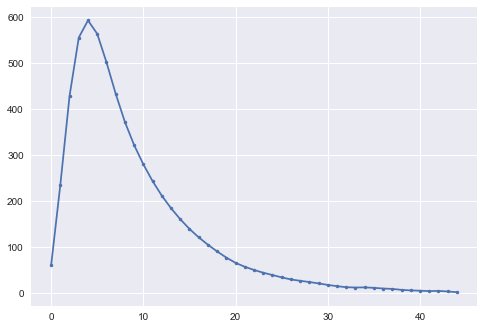

In [10]:
plt.plot(Ys,'.-');

We only want to curve-fit the interesting area. Extract-out just the 80%-20% region (relative to the peak)

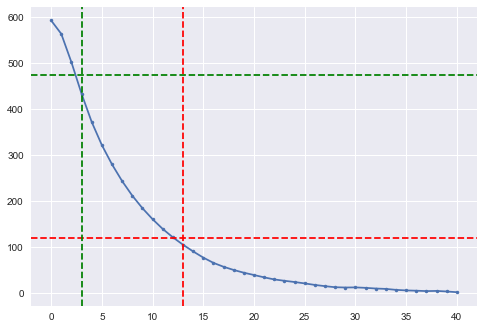

In [11]:
YsOriginal = np.array(Ys) # we will use this later
cutOffPoints=0 # every time we cut off some of the Ys, we will keep track

peakVal=np.max(Ys)
peakI=np.where(Ys==peakVal)[0][0]
Ys=Ys[peakI:]
cutOffPoints+=peakI
plt.plot(Ys,'.-');

upperVal=peakVal*.8
upperI=np.where(Ys<upperVal)[0][0]
lowerVal=peakVal*.2
lowerI=np.where(Ys<lowerVal)[0][0]

plt.axhline(upperVal,color='g',ls='--')
plt.axhline(lowerVal,color='r',ls='--')
plt.axvline(upperI,color='g',ls='--')
plt.axvline(lowerI,color='r',ls='--');

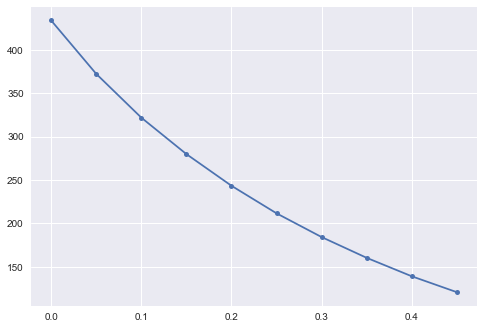

In [12]:
fitThis=Ys[upperI:lowerI]
cutOffPoints+=upperI

Xs=np.arange(len(fitThis))*abfStep.pointDurMS
plt.plot(Xs,fitThis,'.-',ms=10);

Fit this curve with SciPy (and calculate $ tau $)

In [13]:
import scipy.optimize

#def algoMonoExp(x, m, t, b):
    #return m*np.exp(-t*x)+b

def algoMonoExpFixedZero(x, m, t):
    return m*np.exp(-t*x)

params, cv = scipy.optimize.curve_fit(algoMonoExpFixedZero, Xs, fitThis, p0=(1,1e-6))
m,t=params
tau=1/t # units are the same units as Xs

print("tau: %.03f ms"%(tau))

tau: 0.352 ms


Note: When I measure with CJFLab (using 50% and 5%), I get a Cm of 0.357 ms. Note that ClampEx reported 0.250 ms.

Now let's inspect our fit

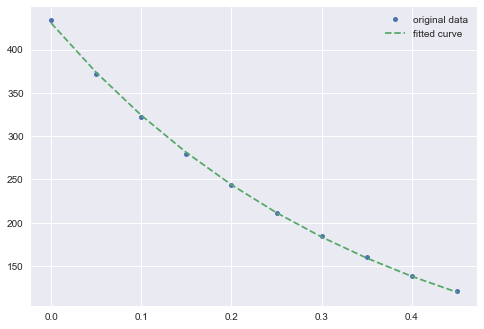

In [14]:
plt.plot(Xs,fitThis,'.',label="original data",ms=10)
plt.plot(Xs,algoMonoExpFixedZero(Xs,m,t),'--',label="fitted curve")
plt.legend();

Let's use our params to extrapolate backwards by `cutOffFirstPoints`

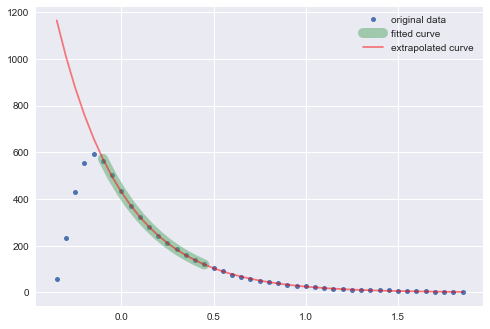

In [15]:
Xs0=np.arange(len(YsOriginal))*abfStep.pointDurMS
Xs0-=(cutOffPoints)*abfStep.pointDurMS
plt.plot(Xs0,YsOriginal,'.',label="original data",ms=10)

Xs2=(np.arange(len(fitThis)+cutOffFirstPoints)-cutOffFirstPoints)*abfStep.pointDurMS
plt.plot(Xs2,algoMonoExpFixedZero(Xs2,m,t),lw=10,alpha=.5,label="fitted curve")

plt.plot(Xs0,algoMonoExpFixedZero(Xs0,m,t),alpha=.5,color='r',label="extrapolated curve")

plt.legend();

From here, we can get $ C_{m} $ using: $ C_{m} = \tau * R_{a} $

Note that $ R_{a} = \Delta V_{m} / I_{0} $, so we could alternatively write: $ C_{m} = \tau * I_{0} / \Delta V_{m} $

... but since we are interested in $ R_{a} $ anyway, let's calculate it

Notice there is a slight difference between dV and dVm. It is shown here. It's so small, I'll ignore it from now, but in the future dVm2 should be used for critical calculations.

In [16]:
I0=algoMonoExpFixedZero(Xs0[2],m,t) # FUDGE FACTOR: why skip two points?
dVm2=dVm*(1-dIm/I0)
print("command dV (mV):",dVm)
print("membrane dV (mV):",dVm2)

command dV (mV): 10.0
membrane dV (mV): 9.77628066163


Calculate $ R_{a} $

In [17]:
Ra = Rm*(dVm/dVm2-1) # MOhm units
print("Ra: %.03f MOhm"%Ra)

Ra: 11.669 MOhm


This is close to clamp-fit's prediction (8 MOhm) but far from CJFLab (16.3 MOhm)

Calculate $ C_{m} $

In [18]:
Cm = (tau*1e-3) / (Ra*1e6) # original MS and MOhm units
print("Cm: %.03f pF"%(Cm*1e12))
print("tau: %.03f ms"%tau)

Cm: 30.146 pF
tau: 0.352 ms


This is pretty close to Clampex. Using 50% to 5% curve fitting, I got a tau of 0.350 ms and Cm of 30.3 pF. These values are right on!

In [19]:
#TODO: get some replicates from different cells and compare clampfit, CJFLab, and this script

# Alternative method to calculate $ C_{m} $ (voltage clamp ramps)
All discussion and code examples up to this point have attempted to calculate capacitance from a voltage step by inspecting the transient. This method uses an abrupt voltage step to cause a capacitive transient in the current trace, and attempts to extract a decay constant from the transient and work from there. 

**Disadvantages of the voltage-step method** stem from the fact that the transient is extremely fast:

* Transients are very fast and greatly susceptible to distortion by hardware low-pass filter
* Transients are very fast and greatly susceptible to noise
* Fitting the transient data to a curve is computationally complex, slow, and can fail
* An unluckily-timed IPSC or EPSC will destroy a meaningful curve fit
* It is a function of access resistance
* It requires knowledge of steady-state currents, which are hard to know if voltage-activated currents exist

**I found it helpful to consider** why the transient is of such interest to measurements of Cm. Try this thought experiment:

* If a cell had 0 pF capacitance, it would effortlessly swing to any command voltage.
* If a cell had 0 pF capacitance, it would charge/discharge instantly, and it would produce no transient.
* The transient is the voltage-clamp amplifier trying to "catch-up" to the fact the cell has not _charged_ to the command voltage yet.
* A cell with a greater _capacity_ to _charge_ is a cell with a high _capacitance_.
* What we are really measuring in the transient is how long it takes the cell to "catch-up" to the command voltage.

Let's use a ramp to generate a small, steady transient (rather than a step to generate a huge, rapidly decaying transient):

In [26]:
abfRamp = pyabf.ABF(R"../data/model_vc_ramp.abf") # model cell
#abfRamp = pyabf.ABF(R"../data/171116sh_0014.abf") # actual neuron

### Break apart the epoch sequences

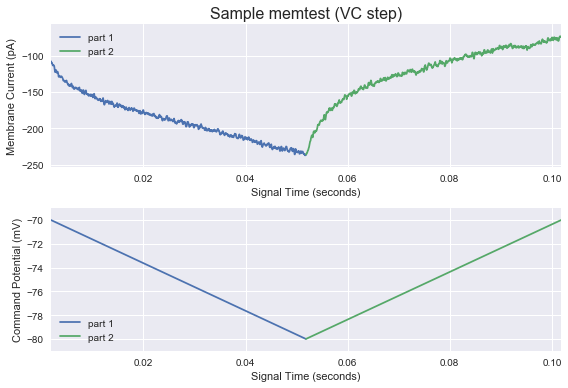

In [27]:
Xs1,Ys1,Cs1=abfRamp.epochData(epochNumber=0)
Xs2,Ys2,Cs2=abfRamp.epochData(epochNumber=1)

plt.subplot(211)
plt.plot(Xs1,Ys1,label="part 1")
plt.plot(Xs2,Ys2,label="part 2")
abfRamp.plotDecorate(legend=True,title="Sample memtest (VC step)")

plt.subplot(212)
plt.plot(Xs1,Cs1,label="part 1")
plt.plot(Xs2,Cs2,label="part 2")
abfRamp.plotDecorate(legend=True,command=True,title=None)

### Determine the voltage clamp slope

In [28]:
dV = np.abs(abfRamp.epochCommand[1]-abfRamp.epochCommand[0])*1e-3 # V
dT = np.abs(abfRamp.epochStartSec[1]-abfRamp.epochStartSec[0]) # S
print("dV:%.02f mV"%(dV*1e3))
print("dT: %.02f ms"%(dT*1e3))
rampSlope = dV/dT
print("slope: %.02f V/S"%(rampSlope))

dV:10.00 mV
dT: 50.00 ms
slope: 0.20 V/S


### Plot $I$ vs. $V$ (rather than $I$ vs. $t$)

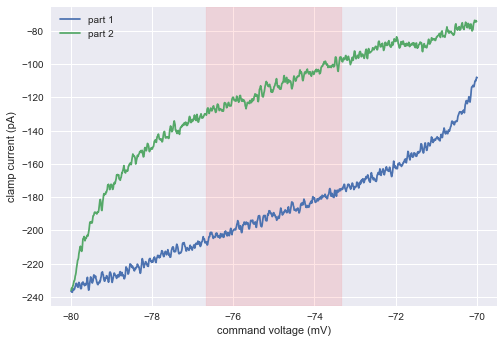

In [29]:
plt.plot(Cs1,Ys1,label="part 1")
plt.plot(Cs2,Ys2,label="part 2")
plt.ylabel("clamp current (pA)")
plt.xlabel("command voltage (mV)")
plt.legend()

# mark the center third
I1,I2=int(len(Ys1)*1/3),int(len(Ys1)*2/3)
plt.axvspan(Cs1[I1],Cs1[I2],color='r',alpha=.1);

### Investigate the difference between the curves

Average: 38.499 pA


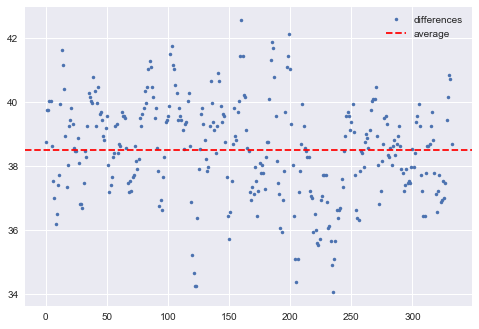

In [30]:
diff = np.abs(Ys1-Ys2[::-1])/(2) # difference from the mean
diff = diff[I1:I2] # get just the center third
diffAvg = np.average(diff)
plt.plot(diff,'.',label="differences")
plt.axhline(diffAvg,color='r',ls='--',label="average")
plt.legend()
print("Average: %.03f pA"%diffAvg)

Divide the average by the slope to yield capacitance

In [31]:
Cm = diffAvg/rampSlope
print("Cm: %.02f pF"%Cm)

Cm: 192.49 pF


Success! This agrees (within 1%) of the step method for calculating Cm.